# Analysis of Ag/O coincidences



# check Fermi Edge calibration

# compare to Ag 3d-MNN for Ag/O samples

# plot linespecs... along cross-lines and more...
   # selected regions ...



experiment in KW26/2019

Sample = Ag(111)+O <br>
Temp = 128 K (-145 C) <br>
Ephot = 850 eV <br>


### load data and settings (path, filenames, flags, binsize)

In [1]:
import sys, os
# own libs from pycoin folder one level above
pycoinpath='../'
sys.path.append(pycoinpath) # add libcoin path here (if not installed as module)
#
ScriptFolder = 'AgO_coins_scripts/'

basepath        = '../testdata'

datafilename='AgO_O1sKLL_KW26_ALL_analysed.h5'
picprefix   ='AgO_O1sKLL_KW26'
#datafilename='AgO_Ag3dMNN_KW26_ALL_analysed.h5'
#picprefix   ='AgO_Ag3dMNN_KW26'

Ephot        = 850 #eV
dxy          = [.2,.1]       # bin resolution in A1,A2 coord.
EkinFermi_xy = [0,0]# kinetic Energy of Fermi for calibration

flag_savefig=False
flag_save2dplot=False

### load settings and data
exec(open(ScriptFolder+"AgO_O1sKLL_Load_settings_and_data.py").read())


 finished loading.


## Analysis

### Select dataset & plot overview

In [2]:
# Ag3dMNN_defineROIframes.py
df=dftrue
exec(open(ScriptFolder+"AgO_defineROIframes.py").read())
#ROIs=None

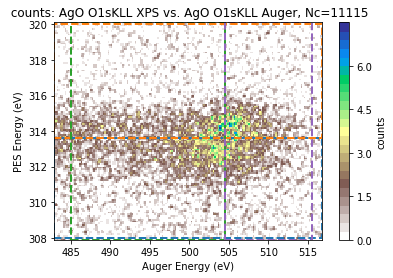

In [3]:
### ### ### ### ### ### ### ### ### ### ### ### ### ###
### plot 2d overview map with frames idicating the ROIs
### ### ### ### ### ### ### ### ### ### ### ### ### ###
if 1:
    tmpflag=[0,0,1]
    # plot raw coin map
    if tmpflag[0]: 
        df=dfcoin.copy() ; figum=1 ; 
        ax1,fig1 = plot_pcolor_map(df,par,fignum=fignum,cmap=cmap
            ,flag_savefig=flag_save2dplot  ### saveing the figure makes it slow!!!
            ,picpostfix='',picprefix=os.path.join(picpath,picprefix)
            ,framecoords=None,framelinestyle='--',framelinewidth=2 )

    # plot acc coin map
    if tmpflag[1]: 
        df=dfacc.copy() ; figum=2 ; 
        ax2,fig2 = plot_pcolor_map(df,par,fignum=fignum,cmap=cmap
            ,flag_savefig=flag_save2dplot  ### saveing the figure makes it slow!!!
            ,picpostfix='',picprefix=os.path.join(picpath,picprefix)
            ,framecoords=None,framelinestyle='--',framelinewidth=2 )

    # plot true coin map
    if tmpflag[2]: 
        df=dftrue.copy() ; figum=3 ; 
        ax3,fig3 = plot_pcolor_map(df,par,fignum=fignum,cmap=cmap
            ,flag_savefig=flag_save2dplot  ### saveing the figure makes it slow!!!
            ,picpostfix='',picprefix=os.path.join(picpath,picprefix)
            ,framecoords=ROIs,framelinestyle='--',framelinewidth=2 )

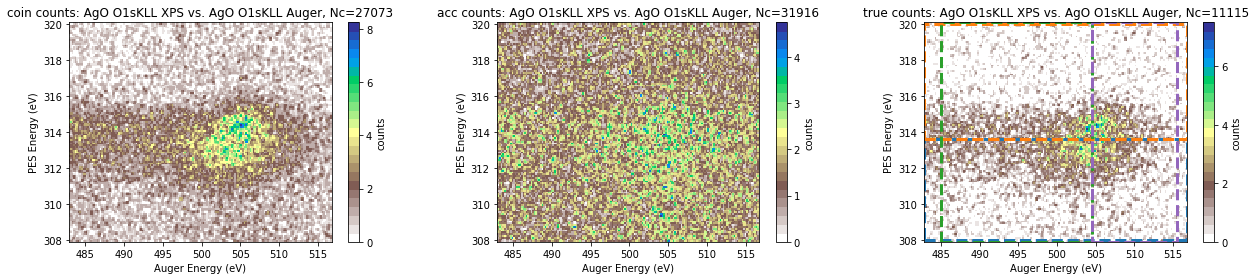

In [4]:
# all 3 maps as horizontal subplot, Frames only in true map
plot_all3maps_frames_in_true_only(dfcoin,dfacc,dftrue
                    ,par ,cmap=cmap,fignum=77
                    ,flag_savefig=flag_save2dplot
                    ,picprefix=os.path.join(picpath,picprefix)
                    ,picpostfix=''
                    ,notitle=False
                    ,print_dxy=False
                    ,invertXaxis=False
                    ,invertYaxis=False
                    ,framecoords=ROIs,framelinestyle='--',framelinewidth=3
                    ,figsize=(18, 4)
                    )
print()

### 2D smoothing & shirley removal

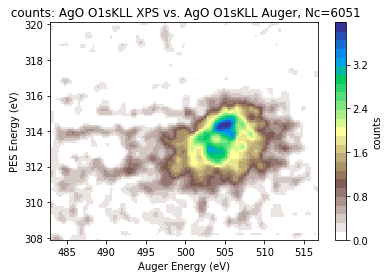

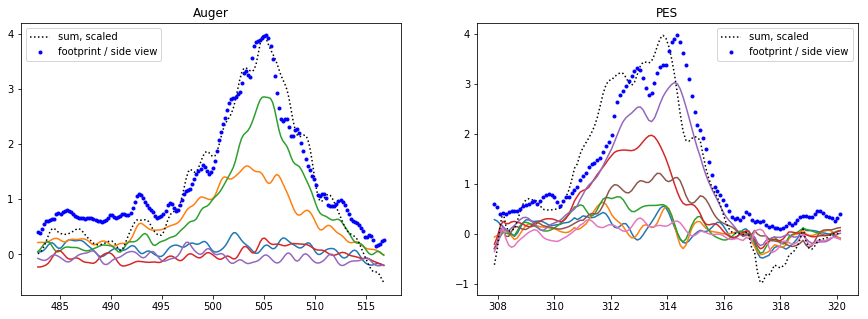

In [5]:
dfin=dftrue.copy()

from libcoin.analyse.shirley  import calc_shirley_2d
from libcoin.analyse.smooth   import moving_average_2d
from libcoin.analyse.smooth   import smooth_with_gaussiankernel
from libcoin.analyse.binning  import bin2d_by_averaging_fixed_span

# binned dataset
binspan = 3
dfbin   = bin2d_by_averaging_fixed_span(dfin , span=binspan, spany=None)

# averaged dataset
avgspan = 3
dfavg   = avgspan*moving_average_2d(dfin , span=avgspan, spany=None)

# gaussian smoothed dataset
sigma_smooth=[2,2]
dfgauss=pd.DataFrame( smooth_with_gaussiankernel(dfin,sigma_smooth) ,index=dfin.index,columns=dfin.columns)

# select dataset to work with & create: dff, dfin, dfBG
#dfin = dfavg
dfin = dfgauss
dfBG = calc_shirley_2d( dfin , edgesize=7)
dff  = dfin - dfBG
#dff  = dftrue.copy() - dfBG

# select dataset to use
df=dff
#df=dfgauss
#df=dfavg
#df=dftrue.copy()
#df=dftrue-dfgauss

# calc footprint/sideview spectra
footprintAuger= df.max(axis=1) 
footprintPES  = df.max(axis=0)

# plot map'n'specs
cc=cmap
#cc='terrain'
threshold=0
flag_plotmap    = True
flag_plot_specs = True
exec(open(ScriptFolder+"AgO_plot_overview_mapNspec.py").read())


print()

### try discretization of map in Z (intensity)
define contour levels and cosntruct new map, where:  z(x,y) = nearestLevel(z(x,y))

[0.6, 0.85]


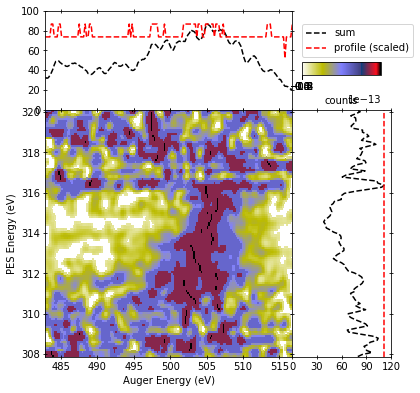

In [61]:
### do not define contour levels, but cutvalues.
### set all values which fall in these intervals to the center of this interval
###  return these centers as list of (calculated) contourlevels


dfz=dff.copy()
dfz-=dfz.min()
dfz/=dfz.max()

cutlevels=np.array([.5,.7,1.])
contlevels=[]
for i in range(1,len(cutlevels)):
    c1=cutlevels[i-1]
    c2=cutlevels[i]
    cc=0.5*(c2+c1) # center
    dfz[ (c1<dfz)&(dfz<c2) ] = cc 
    contlevels.append(cc)

    
print(contlevels)



dftst=dfz

threshold=.1
dftst[dfz<threshold]=np.nan


cc='terrain_r'
cc='nipy_spectral'
cc='gist_ncar'
cc='gist_stern_r'
ax9,fig9 = plot_map_with_spectra(dftst,par,cmap=cc
 #       , Ncolorticks=5, Nticks_topspec=3, Nticks_sidespec=4
        , linplt_sz = 0.4
        , notitle=True
#        , plot_maxtraces_in_map=True
#        , framecoords=ROIs , plot_framesums=True
#        , plot_contourlines=True, contcolors='tab:orange',contcolor=8,contalpha=0.99
        , figsize=(6,6)
        , plot_pcolormesh=True
        ) 


In [41]:
from libcoin.plot.plot_map_with_spectra import * #plot_map_with_specs

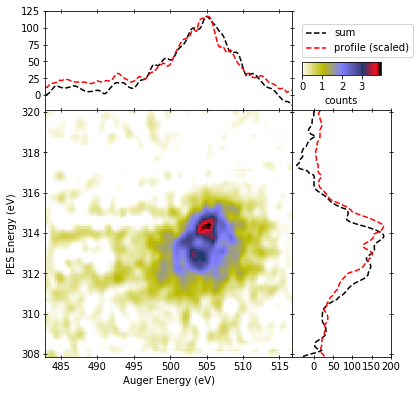

In [52]:
#exec(open(ScriptFolder+"plot_MapWithSpecs.py").read())
sigmatst=[2,2]
tmp=smooth_with_gaussiankernel(dff,sigma=sigmatst)
dftst=pd.DataFrame( tmp ,index=dfin.index,columns=dfin.columns)

dftst=dff
threshold=-.25
cc='terrain_r'
cc='nipy_spectral'
cc='gist_ncar'
cc='gist_stern_r'
ax9,fig9 = plot_map_with_spectra(dftst,par,cmap=cc
 #       , Ncolorticks=5, Nticks_topspec=3, Nticks_sidespec=4
        , linplt_sz = 0.4
        , notitle=True
#        , plot_maxtraces_in_map=True
#        , framecoords=ROIs , plot_framesums=True
#        , plot_contourlines=True, contcolors='tab:orange',contcolor=8,contalpha=0.99
        , figsize=(6,6)
        , plot_pcolormesh=True
        ) 

In [8]:
df=dff.copy()
# calc footprint/sideview spectra
footprintAuger= df.max(axis=1)
sumspecAuger  = df.sum(axis=1)
footprintPES  = df.max(axis=0)
sumspecPES    = df.sum(axis=0)

footprintPES
Ratio of Areas Peak2/Peak1 = 0.279 +/- 0.369
Peak Areas    : 8.516    & 2.377   
Peak sigmas   : 1.511    & 0.663   
Peak gammas   : 11.608    & 329.717   
Peak Positions: 313.237 eV & 314.591 eV


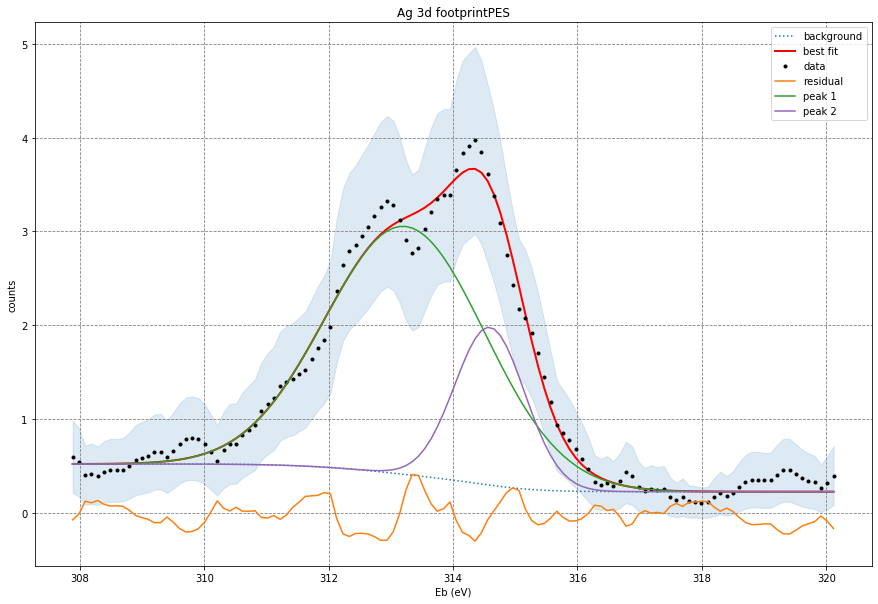


footprintPES
Peak Areas    : 5.210    & 1.634    & 2.824   
Peak sigmas   : 0.994    & 0.466    & 0.766   
Peak gammas   : 1404.366    & 2.693    & 240.182   
Peak Positions: 312.944 eV & 314.274 eV & 314.842 eV & 314.842 eV


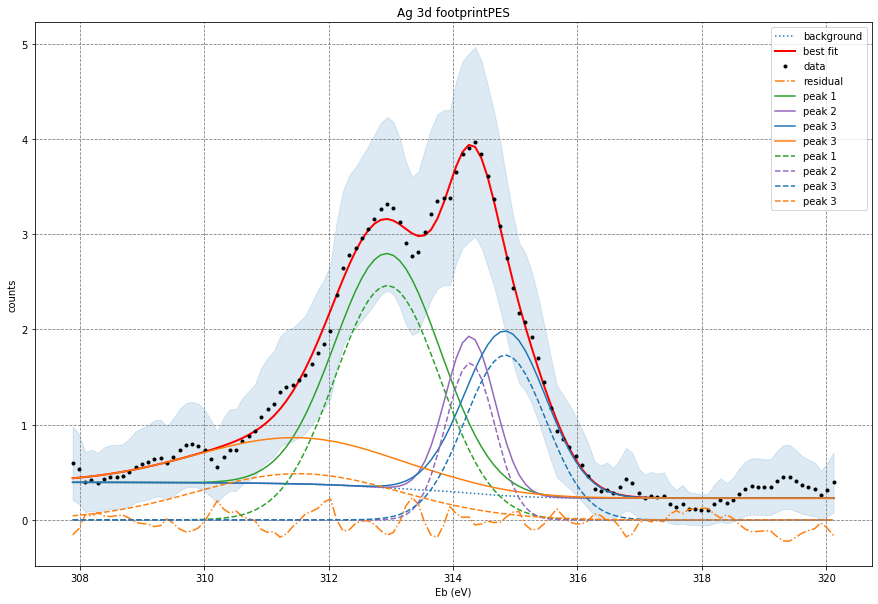

In [9]:
### ### ### ### ### ### ### ### ### ### ### ###
### PES Datasets to be fitted               ###
### ### ### ### ### ### ### ### ### ### ### ###
datdict={}
key='footprintPES' ; datdict[key]=footprintPES
#key='sumspecPES' ; datdict[key]=sumspecPES
peak1_pos = 312.70
peak2_pos = 314.41
peak3_pos = 317.0
peak4_pos = 310.0
dpeak = 5.3
exec(open(ScriptFolder+'AgO_Fit_O1s.py').read())
exec(open(ScriptFolder+'AgO_Fit_Okll.py').read())

footprintAuger
Ratio of Areas Peak2/Peak1 = 0.059 +/- 0.086
Peak Areas    : 26.739    & 1.586   
Peak sigmas   : 4.092    & 1.618   
Peak gammas   : 2437.452    & 162.420   
Peak Positions: 504.730 eV & 512.855 eV


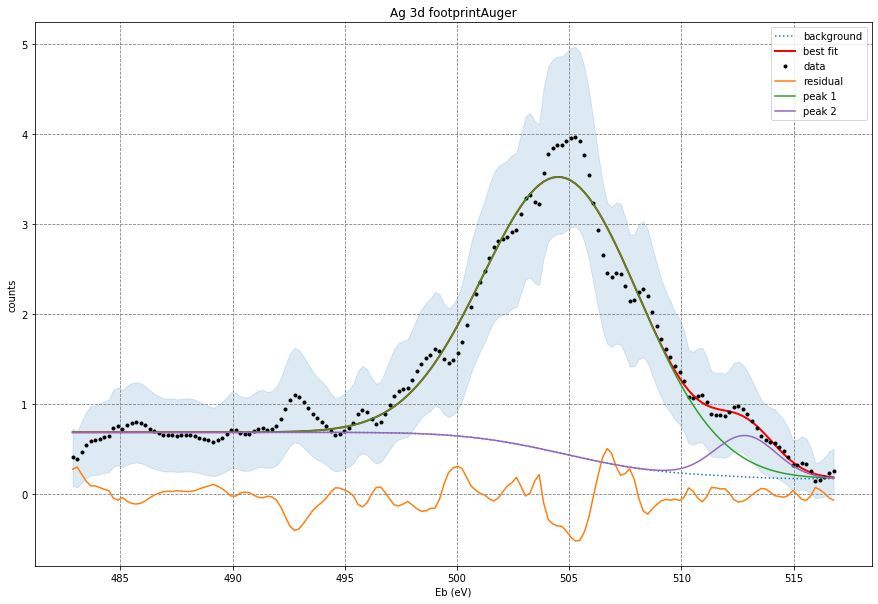


footprintAuger
Peak Areas    : 23.584    & 1.031    & 2.128   
Peak sigmas   : 4.168    & 1.009    & 1.000   
Peak gammas   : 1159.970    & 404.670    & 31.207   
Peak Positions: 504.384 eV & 508.713 eV & 505.023 eV & 505.023 eV


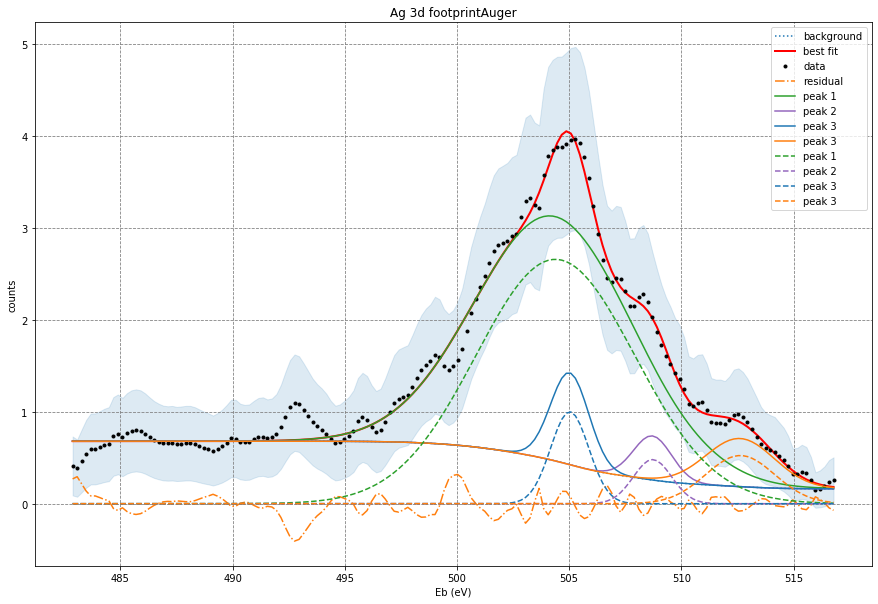

In [10]:
### ### ### ### ### ### ### ### ### ### ### ###
### Auger Datasets to be fitted               ###
### ### ### ### ### ### ### ### ### ### ### ###
datdict={}
key='footprintAuger' ; datdict[key]=footprintAuger
peak1_pos = 504.45
peak2_pos = 510.0
peak3_pos = 505.0
peak4_pos = 511.0
dpeak = 30.05
exec(open(ScriptFolder+'AgO_Fit_O1s.py').read())
exec(open(ScriptFolder+'AgO_Fit_Okll.py').read())

### try 2D Gaussian fit

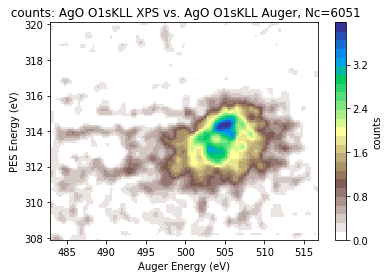

In [11]:
df=(dff).copy()
ax1,fig1 = plot_pcolor_map(df,par,cmap=cmap)

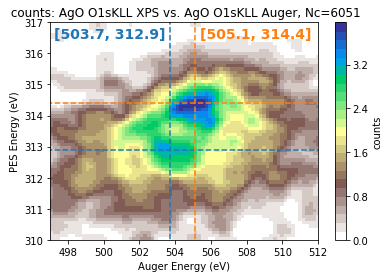

In [12]:
ax,cb=fig1.get_axes()
ax.lines = []

p1xy0=[ 503.7 , 312.9 ]; p1color='tab:blue'
p2xy0=[ 505.1 , 314.4 ]; p2color='tab:orange'

ec=p1xy0 ; color=p1color
ax.plot(ax.get_xlim(),[ec[1],ec[1]],'--',color=color)
ax.plot([ec[0],ec[0]],ax.get_ylim(),'--',color=color)

ec=p2xy0 ; color=p2color
ax.plot(ax.get_xlim(),[ec[1],ec[1]],'--',color=color)
ax.plot([ec[0],ec[0]],ax.get_ylim(),'--',color=color)

ax.set_xlim([497,512])
ax.set_ylim([310,317])

ax.text(497.2,316.5,str(p1xy0),color=p1color,fontsize=14,fontweight='heavy')
ax.text(505.4,316.5,str(p2xy0),color=p2color,fontsize=14,fontweight='heavy')

fig1

counts:  -1.38 ->  1.73
min:    -1.4  at (505.28, 314.05) eV
max:     1.7  at (501.84, 313.65) eV
cm at  ( 496.2, 310.43) eV


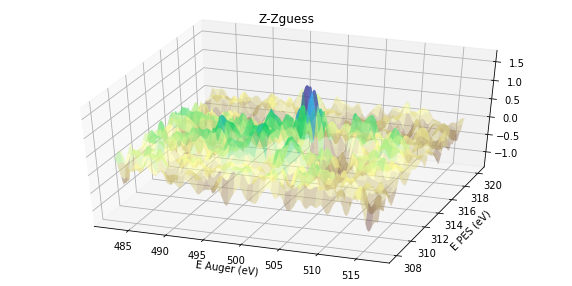

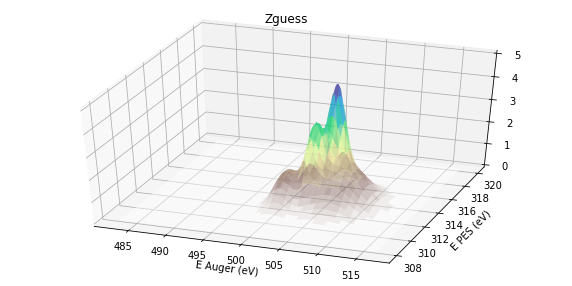

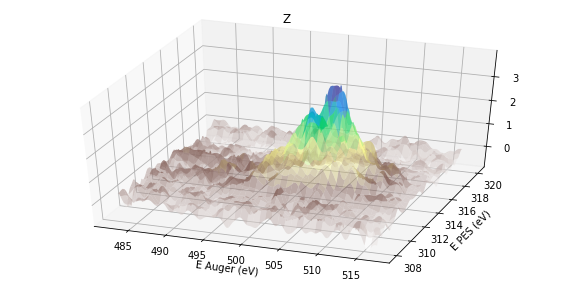

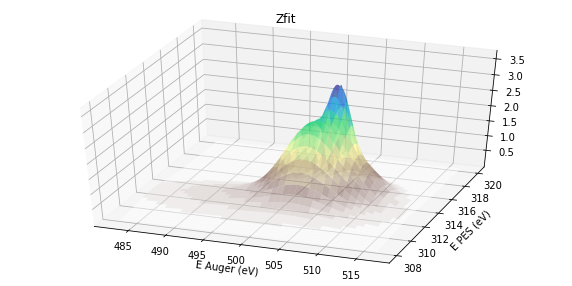

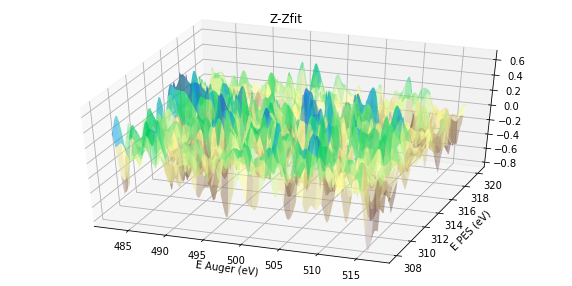

Guessed parameters:
[503.7, 312.8, 1.5, 0.8, 2.61, 505.1, 314.3, 1.5, 0.8, 3.7699999999999996, 500.3, 312.5, 1.9, 1.6, 1.45, 507.0, 313.2, 4, 2, 2.03]
Fitted parameters:
502.98, 312.99,   4.63,   1.58,   2.13
505.15, 314.52,   2.06,   0.79,   2.22
497.96, 311.76,  15.02,   2.33,   0.47
508.22, 313.90,   4.39,   1.93,   1.12
RMS residual = 0.20758417619616037


In [13]:
###### from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D

# The two-dimensional domain of the fit.
xmin, xmax, nx = df.index.min()  , df.index.max()  , df.shape[0]
ymin, ymax, ny = df.columns.min(), df.columns.max(), df.shape[1]
x, y = np.linspace(xmin, xmax, nx), np.linspace(ymin, ymax, ny)
X, Y = np.meshgrid(x, y)
Z = df.T.to_numpy()

# Our function to fit is going to be a sum of two-dimensional Gaussians
def gaussian(x, y, x0, y0, xalpha, yalpha, A):
    return A * np.exp( -((x-x0)/xalpha)**2 -((y-y0)/yalpha)**2)
#
# This is the callable that is passed to curve_fit. M is a (2,N) array
# where N is the total number of data points in Z, which will be ravelled
# to one dimension.
def _gaussian(M, *args):
    x, y = M
    arr = np.zeros(x.shape)
    for i in range(len(args)//5):
        arr += gaussian(x, y, *args[i*5:i*5+5])
    return arr



# A list of the Gaussian parameters / Initial guesses 
# x0, y0, xalpha, yalpha, A
x0 =[503.7 , 505.1 , 500.3, 507.0] 
y0 =[312.8 , 314.3 , 312.5, 313.2]
wx =[1.5   , 1.5   , 1.9   ,   4]
wy =[0.8   , 0.8   , 1.6 , 2]
sc1=0.5
#amp=[sc1*13  , sc1*15    , 4.0  ]
sc2=.29
amp=[sc2*9. , sc2*13.   , sc2*5.  , sc2*7]
#amp=[0  , 0    , 7.0  ]
#amp=[9    , 15    , 7.0  ]
#
guess_prms = [
         (x0[0],y0[0],wx[0],wy[0],amp[0])
        ,(x0[1],y0[1],wx[1],wy[1],amp[1])
        ,(x0[2],y0[2],wx[2],wy[2],amp[2])
        ,(x0[3],y0[3],wx[3],wy[3],amp[3])
        ]
# Flatten the guess parameter list.
p0 = [p for prms in guess_prms for p in prms]
# ravel the data
xydata = np.vstack((X.ravel(), Y.ravel())) ; zdata  = Z.ravel()
Zguess = np.zeros(Z.shape)
for i in range(len(p0)//5):  
    Zguess += gaussian(X, Y, *p0[i*5:i*5+5])

q=Z-Zguess
print("counts: {:6.2f} ->{:6.2f}".format(q.min(),q.max()))
i,j = np.unravel_index(q.argmin(), q.shape)
print("min:  {:6.1f}  at ({:6.2f}, {:6.2f}) eV".format(q[i,j],X[i,j],Y[i,j]) ) 
i,j = np.unravel_index(q.argmax(), q.shape)
print("max:  {:6.1f}  at ({:6.2f}, {:6.2f}) eV".format(q[i,j],X[i,j],Y[i,j]) ) 
# center of mass: R=sum(m_i*R_i)/M
Rx,Ry=0,0
for i in range(q.shape[0]):
    for j in range(q.shape[1]):
        Rx += q[i,j]*X[i,j]
        Ry += q[i,j]*Y[i,j] 
Rx=Rx/q.sum() ; Ry=Ry/q.sum()
print("cm at  ({:6.1f}, {:6.2f}) eV".format(Rx,Ry) ) 

viewinit=(90,-90)
viewinit=(40,-70)
exec(open(ScriptFolder+'AgO_fit2d_try01.py').read())

In [14]:
x0 =[503.7 , 505.1 , 500.3, 507.0] 
y0 =[312.8 , 314.3 , 312.5, 313.2]
wx =[1.5   , 1.5   , 1.9   ,   4]
wy =[0.8   , 0.8   , 1.6 , 2]
sc2=.29
amp=[sc2*9. , sc2*13.   , sc2*5.  , sc2*7]

# take thes values and set up a 4peak 2D multigauss fit with very narrow bounds



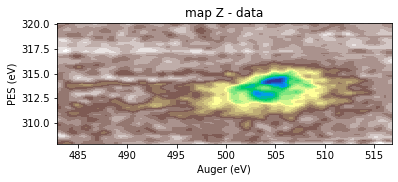

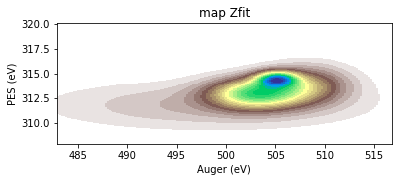

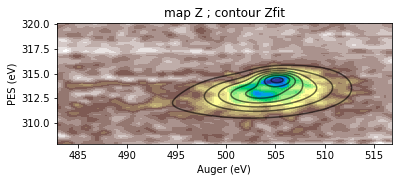

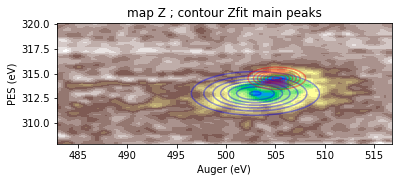

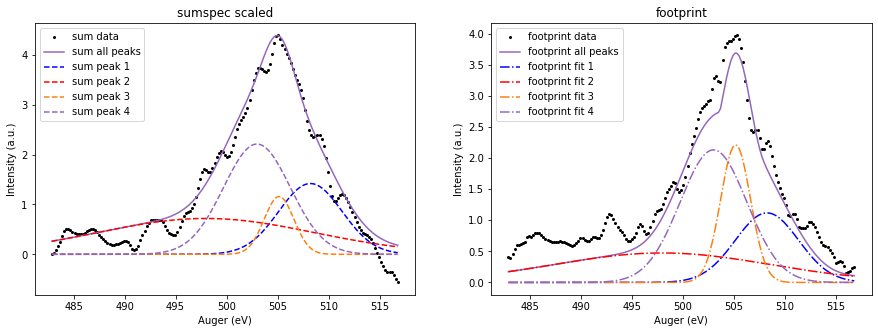

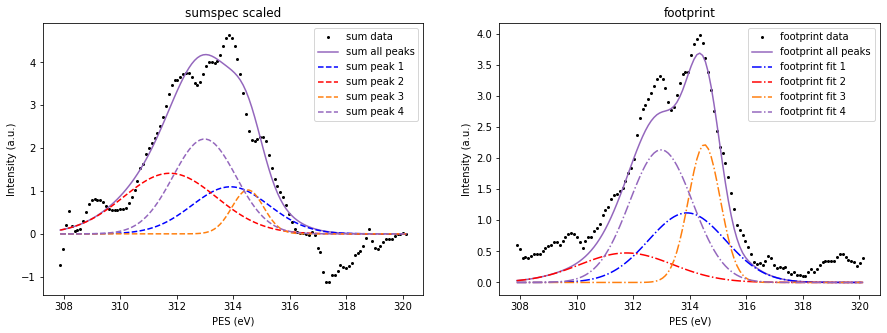

In [15]:
# plots to analyse fit
x=X[0,:]
y=Y[:,0]
Zplot=Z-Zfit
    
contlineapha = .4
cc='plasma'
cc=cmap

if 1:
    # Plot the test data as a 2D image and the fit as overlaid contours.
    fig = plt.figure()
    ax = fig.add_subplot(111) ;  ax.set_title('map Z - data')
    ax.imshow(Z, origin='bottom', cmap=cc,
              extent=(x.min(), x.max(), y.min(), y.max()))
    #ax.contour(X, Y, Zfit, colors='k',alpha=.59, levels=contlevels)
    ax.set_xlabel('Auger (eV)')
    ax.set_ylabel('PES (eV)')
    plt.show()
#
if 1:
    # Plot the test data as a 2D image and the fit as overlaid contours.
    fig = plt.figure()
    ax = fig.add_subplot(111) ;  ax.set_title('map Zfit')
    ax.imshow(Zfit, origin='bottom', cmap=cc,
              extent=(x.min(), x.max(), y.min(), y.max()))
    #ax.contour(X, Y, Zfit, colors='k',alpha=.59, levels=contlevels)
    ax.set_xlabel('Auger (eV)')
    ax.set_ylabel('PES (eV)')
    plt.show()
#
if 1:
    # Plot the test data as a 2D image and the fit as overlaid contours.
    fig = plt.figure()
    ax = fig.add_subplot(111) ;  ax.set_title('map Z ; contour Zfit')
    ax.imshow(Z, origin='bottom', cmap=cc,
              extent=(x.min(), x.max(), y.min(), y.max()))
    ax.contour(X, Y, Zfit, colors='k',alpha=.59)
    ax.set_xlabel('Auger (eV)')
    ax.set_ylabel('PES (eV)')
    plt.show()

ZfitComps = [];#np.zeros(Z.shape)
colors=[]
colors.append('b')
colors.append('r')
colors.append('tab:orange')
colors.append('tab:purple')
colors.append('w')

for i in range(len(popt)//5):
    #Zfit += gaussian(X, Y, *popt[i*5:i*5+5])
    ZfitComps.append( gaussian(X, Y, *popt[i*5:i*5+5]) )
####
if 1:
    # Plot the test data as a 2D image and the fit as overlaid contours.
    fig = plt.figure()
    ax = fig.add_subplot(111) ;  ax.set_title('map Z ; contour Zfit main peaks')
    ax.imshow(Z, origin='bottom', cmap=cc,
              extent=(x.min(), x.max(), y.min(), y.max()))
    for i in range(2):
        j=i
        ax.contour(X, Y, ZfitComps[j], colors=colors[j],alpha=contlineapha)
    ax.set_xlabel('Auger (eV)')
    ax.set_ylabel('PES (eV)')
    plt.show()
###    
if 0:
    # Plot the test data as a 2D image and the fit as overlaid contours.
    fig = plt.figure()
    ax = fig.add_subplot(111) ;  ax.set_title('map Z ; contour Zfit background peaks')
    ax.imshow(Z, origin='bottom', cmap=cc,
              extent=(x.min(), x.max(), y.min(), y.max()))
    for i in range(2):
        j=len(ZfitComps)-i-1
        ax.contour(X, Y, ZfitComps[j], colors=colors[j],alpha=1.5*contlineapha)
    ax.set_xlabel('Auger (eV)')
    ax.set_ylabel('PES (eV)')
    plt.show()
###    
if 0:
    # Plot the test data as a 2D image and the fit as overlaid contours.
    fig = plt.figure()
    ax = fig.add_subplot(111) ;  ax.set_title('map Z ; contour Zfit single peaks')
    ax.imshow(Z, origin='bottom', cmap=cc,
              extent=(x.min(), x.max(), y.min(), y.max()))
    for i in range(len(ZfitComps)):
        j=len(ZfitComps)-i-1
        ax.contour(X, Y, ZfitComps[j], colors=colors[j],alpha=contlineapha)
    ax.set_xlabel('Auger (eV)')
    ax.set_ylabel('PES (eV)')
    plt.show()
###
figsize=(15, 5)
ms=4 # markersize
###
if 1:
    # Plot sumspecs and footprints for fit and data
    # Auger axis
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    xx=x
    axis=0
    scale_footprint=0
    scale_sumspec=0
    footprint=[]
    sumspec=[]
    for i in range(len(ZfitComps)):
        j=len(ZfitComps)-i-1
        tmp=ZfitComps[j].max(axis=axis)
        if tmp.max()>scale_footprint: scale_footprint=tmp.max()
        footprint.append(tmp)
        tmp=ZfitComps[j].sum(axis=axis)
        if tmp.max()>scale_sumspec: scale_sumspec=tmp.max()
        sumspec.append(tmp)

    ax[0].plot(xx, scale_footprint*np.sum(Z,axis=axis)/scale_sumspec  ,'.k',ms=ms,label='sum data')
    ax[0].plot(xx, scale_footprint*np.sum(Zfit,axis=axis)/scale_sumspec  ,'-',color=colors[i],label='sum all peaks')
    ax[1].plot(xx, np.max(Z,axis=axis)  ,'.k',ms=ms,label='footprint data')
    ax[1].plot(xx, np.max(Zfit,axis=axis)  ,'-',color=colors[i],label='footprint all peaks')
    for i in range(len(sumspec)):
        ax[0].plot(xx, scale_footprint*sumspec[i]/scale_sumspec  ,'--',color=colors[i],label='sum peak {:}'.format(i+1))
        ax[1].plot(xx, footprint[i],'-.',color=colors[i],label='footprint fit {:}'.format(i+1))
    ax[0].legend(); ax[0].set_xlabel('Auger (eV)'); ax[0].set_ylabel('Intensity (a.u.)')
    ax[1].legend(); ax[1].set_xlabel('Auger (eV)'); ax[1].set_ylabel('Intensity (a.u.)')
    ax[0].set_title('sumspec scaled')
    ax[1].set_title('footprint')
    plt.show()
###    
if 1:
    # Plot sumspecs and footprints for fit and data
    # PES axis
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    xx=y
    axis=1
    scale_footprint=0
    scale_sumspec=0
    footprint=[]
    sumspec=[]
    for i in range(len(ZfitComps)):
        j=len(ZfitComps)-i-1
        tmp=ZfitComps[j].max(axis=axis)
        if tmp.max()>scale_footprint: scale_footprint=tmp.max()
        footprint.append(tmp)
        tmp=ZfitComps[j].sum(axis=axis)
        if tmp.max()>scale_sumspec: scale_sumspec=tmp.max()
        sumspec.append(tmp)

    ax[0].plot(xx, scale_footprint*np.sum(Z,axis=axis)/scale_sumspec  ,'.k',ms=ms,label='sum data')
    ax[0].plot(xx, scale_footprint*np.sum(Zfit,axis=axis)/scale_sumspec  ,'-',color=colors[i],label='sum all peaks')
    ax[1].plot(xx, np.max(Z,axis=axis)  ,'.k',ms=ms,label='footprint data')
    ax[1].plot(xx, np.max(Zfit,axis=axis)  ,'-',color=colors[i],label='footprint all peaks')
    for i in range(len(sumspec)):
        ax[0].plot(xx, scale_footprint*sumspec[i]/scale_sumspec  ,'--',color=colors[i],label='sum peak {:}'.format(i+1))
        ax[1].plot(xx, footprint[i],'-.',color=colors[i],label='footprint fit {:}'.format(i+1))
    ax[0].legend(); ax[0].set_xlabel('PES (eV)'); ax[0].set_ylabel('Intensity (a.u.)')
    ax[1].legend(); ax[1].set_xlabel('PES (eV)'); ax[1].set_ylabel('Intensity (a.u.)')
    ax[0].set_title('sumspec scaled')
    ax[1].set_title('footprint')
    plt.show()


# guess from 1D footprint fits
keep peak pos and widths in bounds
# add shirley to fit
# rotating gaussians
# 2d voigt profiles

In [16]:
if 0:
    import numpy as np
    from scipy.optimize import curve_fit
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D

    # The two-dimensional domain of the fit.
    xmin, xmax, nx = -5, 4, 75
    ymin, ymax, ny = -3, 7, 150
    x, y = np.linspace(xmin, xmax, nx), np.linspace(ymin, ymax, ny)
    X, Y = np.meshgrid(x, y)

    # Our function to fit is going to be a sum of two-dimensional Gaussians
    def gaussian(x, y, x0, y0, xalpha, yalpha, A):
        return A * np.exp( -((x-x0)/xalpha)**2 -((y-y0)/yalpha)**2)

    # A list of the Gaussian parameters: x0, y0, xalpha, yalpha, A
    gprms = [(0, 2, 2.5, 5.4, 1.5),
             (-1, 4, 6, 2.5, 1.8),
             (-3, -0.5, 1, 2, 4),
             (3, 0.5, 2, 1, 5)
            ]

    # Standard deviation of normally-distributed noise to add in generating
    # our test function to fit.
    noise_sigma = 0.1

    # The function to be fit is Z.
    Z = np.zeros(X.shape)
    for p in gprms:
        Z += gaussian(X, Y, *p)
    Z += noise_sigma * np.random.randn(*Z.shape)

    # Plot the 3D figure of the fitted function and the residuals.
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(X, Y, Z, cmap='plasma')
    ax.set_zlim(0,np.max(Z)+2)
    plt.show()

    # This is the callable that is passed to curve_fit. M is a (2,N) array
    # where N is the total number of data points in Z, which will be ravelled
    # to one dimension.
    def _gaussian(M, *args):
        x, y = M
        arr = np.zeros(x.shape)
        for i in range(len(args)//5):
           arr += gaussian(x, y, *args[i*5:i*5+5])
        return arr

    # Initial guesses to the fit parameters.
    guess_prms = [(0, 0, 1, 1, 2),
                  (-1.5, 5, 5, 1, 3),
                  (-4, -1, 1.5, 1.5, 6),
                  (4, 1, 1.5, 1.5, 6.5)
                 ]
    # Flatten the initial guess parameter list.
    p0 = [p for prms in guess_prms for p in prms]

    # We need to ravel the meshgrids of X, Y points to a pair of 1-D arrays.
    xdata = np.vstack((X.ravel(), Y.ravel()))
    # Do the fit, using our custom _gaussian function which understands our
    # flattened (ravelled) ordering of the data points.
    popt, pcov = curve_fit(_gaussian, xdata, Z.ravel(), p0)
    fit = np.zeros(Z.shape)
    for i in range(len(popt)//5):
        fit += gaussian(X, Y, *popt[i*5:i*5+5])
    print('Fitted parameters:')
    print(popt)

    rms = np.sqrt(np.mean((Z - fit)**2))
    print('RMS residual =', rms)

    # Plot the 3D figure of the fitted function and the residuals.
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(X, Y, fit, cmap='plasma')
    cset = ax.contourf(X, Y, Z-fit, zdir='z', offset=-4, cmap='plasma')
    ax.set_zlim(-4,np.max(fit))
    plt.show()

    # Plot the test data as a 2D image and the fit as overlaid contours.
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(Z, origin='bottom', cmap='plasma',
              extent=(x.min(), x.max(), y.min(), y.max()))
    ax.contour(X, Y, fit, colors='w')
    plt.show()
